In [137]:
# general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# gradient descent
from gd.optimization import GDClassifier, SGDClassifier
from gd.oracles import BinaryLogistic
from gd.utils import grad_finite_diff

# statistic
import pylab 
from scipy.stats import probplot
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import laplace

# text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import wordnet
from nltk import WordNetLemmatizer
from nltk import pos_tag
from nltk import download
from nltk.corpus import stopwords
download('averaged_perceptron_tagger')
download('wordnet')
download('omw-1.4')
download('stopwords')
stopWords = stopwords.words('english')

# utility
from tqdm.notebook import tqdm_notebook as tqdm
import dill
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
sns.set_theme(palette='deep', style='whitegrid')

In [3]:
! gdown https://drive.google.com/uc?id=1a-O_gckKyVRQPF5RhBxo-RnZBEGpezE0  
! unzip data_toxic

Downloading...
From: https://drive.google.com/uc?id=1a-O_gckKyVRQPF5RhBxo-RnZBEGpezE0
To: /content/data_toxic.zip
100% 11.0M/11.0M [00:00<00:00, 50.2MB/s]
Archive:  data_toxic.zip
  inflating: toxic_test.csv          
  inflating: toxic_train.csv         


- На валидационной выборке будем проводить эксперименты 4, 5 и искать оптимальные параметры
- На обучающей выборке -- строить модель
- На тестовой выборке -- мерить качество лучшей модели

In [4]:
# load train dataset
df = pd.read_csv('toxic_train.csv')

# drop id column
df.drop(columns='Unnamed: 0', inplace=True)

# create validation dataset
df_val = df.sample(frac=0.2, random_state=42)
df.drop(df_val.index, inplace=True)

print(f'train size: {df.shape[0]}, validation size: {df_val.shape}')

df.head()

train size: 41649, validation size: (10412, 2)


,comment_text,is_toxic
0,Explanation\nWhy the edits made under my usern...,False
1,D'aww! He matches this background colour I'm s...,False
2,"Hey man, I'm really not trying to edit war. It...",False
3,"""\nMore\nI can't make any real suggestions on ...",False
5,"""\n\nCongratulations from me as well, use the ...",False


In [5]:
# load test dataset
df_test = pd.read_csv('toxic_test.csv')

# drop id column
df_test.drop(columns='Unnamed: 0', inplace=True)

print(f'test size: {df_test.shape[0]}')

df_test.head()

test size: 20676


,comment_text,is_toxic
0,Thank you for understanding. I think very high...,False
1,:Dear god this site is horrible.,False
2,"""::: Somebody will invariably try to add Relig...",False
3,""" \n\n It says it right there that it IS a typ...",False
4,""" \n\n == Before adding a new product to the l...",False


# Эксперимент 1. Предобработка

Произведите предварительную обработку текста. Приведите все тексты к нижнему регистру. Замените в
тексте все символы, не являющиеся буквами и цифрами, на пробелы.

**Замечание**. Полезные функции: `str.lower`, `str.split`, `str.isalnum`, `re.sub`, `re.split`

In [6]:
def str_format(df_column):
  ans = df_column.copy()
  ans = ans.str.lower()
  ans = ans.str.replace(pat=r'[^\da-z]', repl=' ', regex=True)
  ans = ans.str.replace(pat=r'\s+', repl=' ', regex=True)
  ans = ans.str.replace(pat=r'^\s+', repl='', regex=True)
  return ans

In [7]:
df['comment_text'] = str_format(df.comment_text)
df_val['comment_text'] = str_format(df_val.comment_text)
df_test['comment_text'] = str_format(df_test.comment_text)
df.head()

,comment_text,is_toxic
0,explanation why the edits made under my userna...,False
1,d aww he matches this background colour i m se...,False
2,hey man i m really not trying to edit war it s...,False
3,more i can t make any real suggestions on impr...,False
5,congratulations from me as well use the tools ...,False


# Эксперимент 2. Векторизация

Преобразуйте выборку в разреженную матрицу `scipy.sparse.csr_matrix`, где значение `x` в позиции `(i,j)`
означает, что в документе `i` слово `j` встретилось `x` раз. Разрешается воспользоваться конструктором
`sklearn.feature_extraction.text.CountVectorizer`.

**Замечание 1**. У `CountVectorizer` есть несколько методов для работы, используйте `fit_transform` и `fit`
для обучающей выборки, используйте `transform` для тестовой.

**Замечание 2.** Используйте параметр `min_df`, чтобы уменьшить размерность данных и ускорить проведение экспериментов

In [8]:
bow_vectorizer = CountVectorizer()
bow = bow_vectorizer.fit_transform(df.comment_text)
bow_val = bow_vectorizer.transform(df_val.comment_text)
bow_test = bow_vectorizer.transform(df_test.comment_text)

In [9]:
bow.shape[1], bow_val.shape[1], bow_test.shape[1]

(78694, 78694, 78694)

In [10]:
bow_vectorizer = CountVectorizer(min_df=0.0001)
bow = bow_vectorizer.fit_transform(df.comment_text)
bow_val = bow_vectorizer.transform(df_val.comment_text)
bow_test = bow_vectorizer.transform(df_test.comment_text)

In [11]:
bow.shape[1], bow_val.shape[1], bow_test.shape[1]

(15948, 15948, 15948)

In [12]:
y_train = (df.is_toxic * 2 - 1).to_numpy()
y_val = (df_val.is_toxic * 2 - 1).to_numpy()
y_test = (df_test.is_toxic * 2 - 1).to_numpy()

# Эксперимент 3. Сравнение GD и `grad_finite_diff`

Реализуйте методы градиентного и стохастического градиентного спуска в соответствии с требованиями
к реализации. Сравните численный подсчет градиента функции потерь из модуля `utils.py` с вычислением
по аналитической формуле.

## Искуственные данные

In [ ]:
solver = BinaryLogistic()

ells = [100, 1000, 10000]
ds = [50, 500, 5000]

num_res = []
for l, d in zip(ells, ds):
  X = np.random.exponential(scale=10, size=(l, d)) * 10
  y = np.random.randint(low=0, high=2, size=l) * 2 - 1
  w = np.random.rand(d)
  g_anal = solver.grad(X, y, w)
  g_num = grad_finite_diff(solver.func, w, X=X, y=y, eps=1e-3)
  num_res.append(np.linalg.norm(g_anal - g_num))

In [ ]:
num_res

[9.911069734691718e-10, 2.5425216614724153e-08, 1.398466186373647e-06]

# Эксперимент 4. GD

Исследуйте поведение градиентного спуска для задачи логистической регрессии в зависимости от следующих параметров:

- параметр размера шага `step_alpha`
- параметр размера шага `step_beta`
- начального приближения

$$
\eta_k={\alpha\over k^\beta}
$$

Исследование поведения подразумевает анализ следуюших зависимостей:

- зависимость значения функции потерь от итерации метода (эпохи в случае стохастического варианта)
- зависимость точности (accuracy) итерации метода (эпохи в случае стохастического варианта)
- При желании можно проанализировать зависимость значения функции потерь и зависимость точности от реального времени работы метода и их отличия от зависимости от итерации.

## Шаг vs accuracy

In [14]:
def calc_accuracy(weights_history):
  global bow_val, y_val
  accuracy = []
  for weights in weights_history:    
    y_pred = np.sign(bow_val @ weights)
    score = (y_pred == y_val).mean()
    accuracy.append(score)
  return accuracy

In [ ]:
m = 4
n = 4
step_alphas = np.linspace(1, 3, m)
step_betas = np.linspace(0, 0.4, n)
step_results = {}
for alpha in step_alphas:
  step_results[alpha] = {}
  for beta in step_betas:
    gd_model = GDClassifier(max_iter=500, step_alpha=alpha, step_beta=beta)
    history = gd_model.fit(bow, y_train, trace=True)
    history['accuracy'] = calc_accuracy(history['weights'])
    del history['weights']
    step_results[alpha][beta] = history

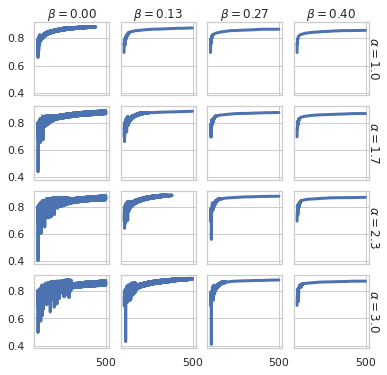

In [ ]:
fig, axes = plt.subplots(m, n, figsize=(n*1.5, m*1.5), sharey=True, sharex=True)
for i, alpha in enumerate(step_alphas):
  for j, beta in enumerate(step_betas):
    axes[i, j].plot(step_results[alpha][beta]['accuracy'], linewidth=3)
    # axes[i, j].set_ylim([0.7, 0.9])
    # axes[i, j].set_xscale('symlog')
    axes[i, j].set(xticks=[500])
    # axes[i, j].tick_params(axis='x',          
    #                        which='both',      
    #                        bottom=False,      
    #                        top=False,         
    #                        labelbottom=False)
    # axes[i, j].xaxis.grid()

for i, alpha in enumerate(step_alphas):
  axes[i, -1].yaxis.set_label_position('right')
  axes[i, -1].set_ylabel(f'$\\alpha=${alpha:.1f}', rotation=-90)
  axes[i, -1].yaxis.set_label_coords(1.15, 0.5)

for j, beta in enumerate(step_betas):
  axes[0, j].xaxis.set_label_position('top')
  axes[0, j].set_xlabel(f'$\\beta=${beta:.2f}')
  
plt.subplots_adjust(wspace=0.15, hspace=0.15)
plt.savefig('/content/drive/MyDrive/mmp_gd/accur_step_rough.pdf', bbox_inches='tight')
plt.show()

## Шаг vs loss

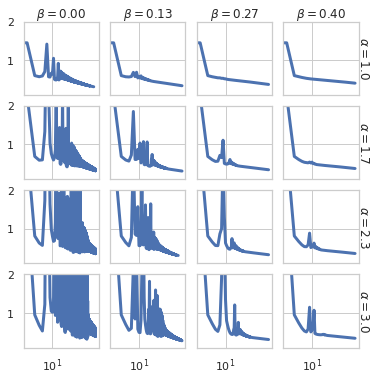

In [ ]:
fig, axes = plt.subplots(m, n, figsize=(n*1.5, m*1.5), sharey=True, sharex=True)
for i, alpha in enumerate(step_alphas):
  for j, beta in enumerate(step_betas):
    axes[i, j].plot(step_results[alpha][beta]['func'], linewidth=3)
    axes[i, j].set_ylim([0.1, 2])
    axes[i, j].set_xscale('log')
    # axes[i, j].set_xticklabels([ 500])    

for i, alpha in enumerate(step_alphas):
  axes[i, -1].yaxis.set_label_position('right')
  axes[i, -1].set_ylabel(f'$\\alpha=${alpha:.1f}', rotation=-90)
  axes[i, -1].yaxis.set_label_coords(1.15, 0.5)

for j, beta in enumerate(step_betas):
  axes[0, j].xaxis.set_label_position('top')
  axes[0, j].set_xlabel(f'$\\beta=${beta:.2f}')
  
plt.subplots_adjust(wspace=0.15, hspace=0.15)
plt.savefig('/content/drive/MyDrive/mmp_gd/loss_step_rough.pdf', bbox_inches='tight')
plt.show()

### Нестабильные модели

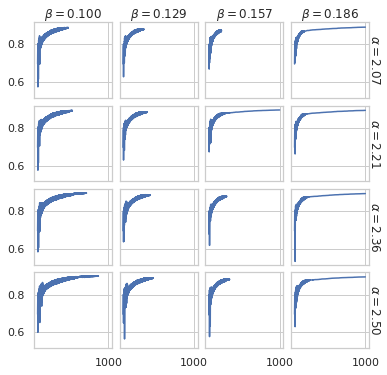

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(6, 6), sharey=True, sharex=True)
for i, alpha in enumerate(step_alphas[4:]):
  for j, beta in enumerate(step_betas[:4]):
    axes[i, j].plot(cv_results[alpha][beta]['accuracy'])
                    # label=f'$\\alpha=${alpha:.2f}\n$\\beta=${beta:.2f}')
    # axes[i, j].set_ylim([0.8, 0.9])
    axes[i, j].set(xticks=[1000])

for i, alpha in enumerate(step_alphas[4:]):
  axes[i, -1].yaxis.set_label_position('right')
  axes[i, -1].set_ylabel(f'$\\alpha=${alpha:.2f}', rotation=-90)
  axes[i, -1].yaxis.set_label_coords(1.15, 0.5)

for j, beta in enumerate(step_betas[:4]):
  axes[0, j].xaxis.set_label_position('top')
  axes[0, j].set_xlabel(f'$\\beta=${beta:.3f}')
  
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('/content/drive/MyDrive/mmp_gd/accur_step_worst.pdf', bbox_inches='tight')
plt.show()

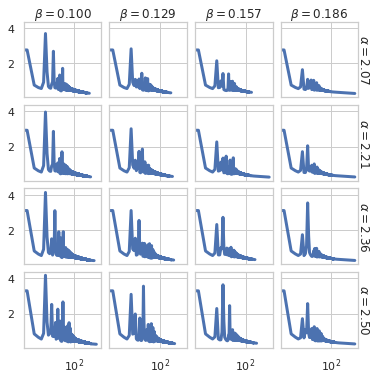

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(6, 6), sharey=True, sharex=True)
for i, alpha in enumerate(step_alphas[4:]):
  for j, beta in enumerate(step_betas[:4]):
    axes[i, j].plot(cv_results[alpha][beta]['func'], linewidth=3)
                    # label=f'$\\alpha=${alpha:.2f}\n$\\beta=${beta:.2f}')
    # axes[i, j].set_ylim([0.8, 0.9])
    # axes[i, j].set(xticks=[1000])
    axes[i, j].set(xscale='log')

for i, alpha in enumerate(step_alphas[4:]):
  axes[i, -1].yaxis.set_label_position('right')
  axes[i, -1].set_ylabel(f'$\\alpha=${alpha:.2f}', rotation=-90)
  axes[i, -1].yaxis.set_label_coords(1.15, 0.5)

for j, beta in enumerate(step_betas[:4]):
  axes[0, j].xaxis.set_label_position('top')
  axes[0, j].set_xlabel(f'$\\beta=${beta:.3f}')
  
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('/content/drive/MyDrive/mmp_gd/loss_step_worst.pdf', bbox_inches='tight')
plt.show()

## $w_0$ vs accuracy

### Распределение весов модели

Изучим распределение получающихся коэффициентов.
- Подберём возможные параметрические семейства
- Оценим параметры методом максимального правдоподобия
- Засемплируем полученные распределения и используем в качестве начального приближения

In [259]:
gd_model = GDClassifier(max_iter=1000, step_alpha=1.93, step_beta=0.21)
gd_history = gd_model.fit(bow, y_train, trace=True)

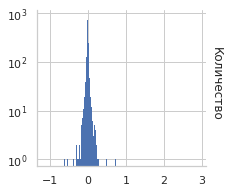

In [266]:
clean_coefs = gd_model.coefs


ax = sns.displot(clean_coefs, aspect=1.2, height=2.8, linewidth=0, alpha=1,)

ax.set(xlabel='')
ax.set(ylabel='', yscale='log')

plt.text(0.99, 0.57, 'Количество', ha='center', va='center', transform=plt.gcf().transFigure, rotation=-90)

plt.savefig('/content/drive/MyDrive/mmp_gd/weights_distribution.pdf', bbox_inches='tight')
plt.show()

In [261]:
# drop outliers
low = np.quantile(clean_coefs, 0.01)
high = np.quantile(clean_coefs, 0.99)
mask = (clean_coefs > low) & (clean_coefs < high)
clean_coefs = clean_coefs[mask]

-0.18, 0.37


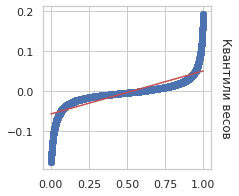

In [262]:
u_loc, u_scale = uniform.fit(clean_coefs)

print(f'{u_loc:.2f}, {u_scale:.2f}')

fig, ax = plt.subplots(figsize=(3,3))
probplot(clean_coefs, dist='uniform', plot=plt)
ax.set_xlabel(f'')
ax.set_ylabel(f'Квантили весов', rotation=-90)
ax.yaxis.set_label_position('right')
# ax.xaxis.set_label_position('top')
# ax.xaxis.set_label_coords(0.5, 1.08)
ax.yaxis.set_label_coords(1.13, 0.5)
ax.set_title(label='')
plt.savefig('/content/drive/MyDrive/mmp_gd/weights_unif.pdf', bbox_inches='tight')
plt.show()

-0.00, 0.04


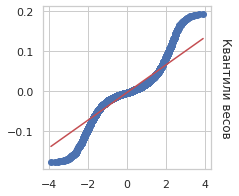

In [263]:
n_loc, n_scale = norm.fit(clean_coefs)

print(f'{n_loc:.2f}, {n_scale:.2f}')

fig, ax = plt.subplots(figsize=(3,3))
probplot(clean_coefs, dist='norm', plot=plt)
ax.set_xlabel(f'')
ax.set_ylabel(f'Квантили весов', rotation=-90)
ax.yaxis.set_label_position('right')
# ax.xaxis.set_label_position('top')
# ax.xaxis.set_label_coords(0.5, 1.08)
ax.yaxis.set_label_coords(1.13, 0.5)
ax.set_title(label='')
plt.savefig('/content/drive/MyDrive/mmp_gd/weights_norm.pdf', bbox_inches='tight')
plt.show()

-0.00, 0.02


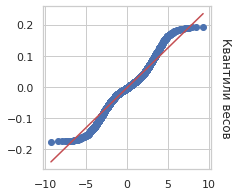

In [264]:
l_loc, l_scale = laplace.fit(clean_coefs)

print(f'{l_loc:.2f}, {l_scale:.2f}')

fig, ax = plt.subplots(figsize=(3,3))
probplot(clean_coefs, dist='laplace', plot=plt)
ax.set_xlabel(f'')
ax.set_ylabel(f'Квантили весов', rotation=-90)
ax.yaxis.set_label_position('right')
# ax.xaxis.set_label_position('top')
# ax.xaxis.set_label_coords(0.5, 1.08)
ax.yaxis.set_label_coords(1.13, 0.5)
ax.set_title(label='')
plt.savefig('/content/drive/MyDrive/mmp_gd/weights_lapl.pdf', bbox_inches='tight')
plt.show()

In [ ]:
def init_uniform(loc, scale, size):
  return uniform.rvs(u_loc, u_scale, size)

def init_norm(loc, scale, size):
  return norm.rvs(n_loc, n_scale, size)

def init_laplace(loc, scale, size):
  return laplace.rvs(l_loc, l_scale, size)

def init_const(const, size):
  return np.full(size, const)

init_dict = {
    'norm': init_norm,
    'uniform': init_uniform,
    'laplace': init_laplace,
    'const': init_const
  }

### Эксперименты

In [ ]:
gd_model = GDClassifier(max_iter=500, step_alpha=1.62, step_beta=0.2)
gd_history = gd_model.fit(bow, y_train)

In [ ]:
from functools import partial
init_methods = [
    
    # theory
    partial(init_uniform, u_loc, u_scale),
    partial(init_laplace, l_loc, l_scale),
    partial(init_norm, n_loc, n_scale),
    
    # practice
    partial(init_uniform, -1, 2),
    partial(init_uniform, 0.2, 0.6),
    partial(init_const, .0),
    partial(init_norm, 0, n_scale),
    partial(init_norm, 0.5, n_scale),
    partial(init_const, 1.),

]

method_names = [
    'clean MML unif',
    'clean MML lapl',
    'clean MML norm',
    'Uniform[-1, 1]',
    'Uniform[0.2, 0.8]',
    'zeros',
    r'Norm(0, $\sigma_{clMML}$)',
    r'Norm(0.5, $\sigma_{clMML}$)',
    'ones'
]

In [ ]:
init_results = []
for init in init_methods:
  w_0 = init(size=bow.shape[1])
  gd_model = GDClassifier(max_iter=500, step_alpha=2, step_beta=0.21)
  history = gd_model.fit(bow, y_train, w_0=w_0, trace=True)
  history['accuracy'] = calc_accuracy(history['weights'])
  history['score'] = calc_final_accuracy(history['weights'][-1])
  del history['weights']
  init_results.append(history)

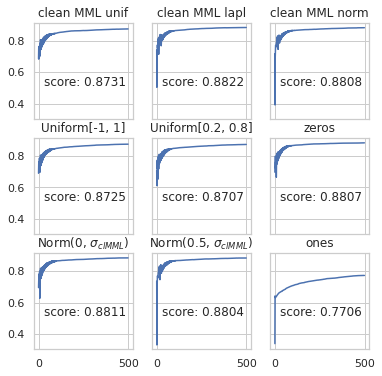

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(6,6), sharex=True, sharey=True)

init_scores = np.empty((3,3))
for k, name in enumerate(method_names):
  axes[k//3, k%3].plot(init_results[k]['accuracy'])
  axes[k//3, k%3].set_title(name)
  score = init_results[k]['score']
  init_scores[k//3, k%3] = score
  axes[k//3, k%3].text(0.1, 0.35,
                       f'score: {score:.4f}',
                       transform=axes[k//3, k%3].transAxes)

plt.savefig('/content/drive/MyDrive/mmp_gd/init_weights.pdf', bbox_inches='tight')
plt.show()

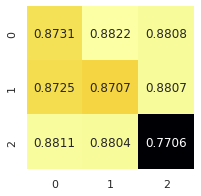

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(init_scores, annot=True, cbar=False, fmt='.4f', cmap='inferno', ax=ax)
plt.savefig('/content/drive/MyDrive/mmp_gd/accur_init_weights.pdf', bbox_inches='tight')
plt.show()

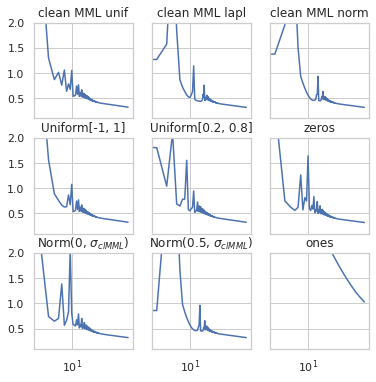

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(6,6), sharex=True, sharey=True)

init_scores = np.empty((3,3))
for k, name in enumerate(method_names):
  axes[k//3, k%3].plot(init_results[k]['func'])
  axes[k//3, k%3].set(title=name,
                      xscale='log',
                      ylim=[0.1,2])

plt.savefig('/content/drive/MyDrive/mmp_gd/init_weights_loss.pdf', bbox_inches='tight')
plt.show()

# Эксперимент 5. SGD

## Шаг & `batch_size` vs accuracy

In [49]:
m = 4
n = 4
k = 3
step_alphas = np.linspace(2.5, 3.5, m)
step_betas = np.linspace(0, 0.3, n)
batch_sizes = np.linspace(100, 500, k)
sgd_step_results = {}
for alpha in tqdm(step_alphas, desc='alpha'):
  sgd_step_results[alpha] = {}
  for beta in tqdm(step_betas, desc='beta'):
    sgd_step_results[alpha][beta] = {}
    for batch_size in batch_sizes:
      sgd_model = SGDClassifier(batch_size=int(batch_size),
                                max_iter=1500,
                                step_alpha=alpha, step_beta=beta)
      history = sgd_model.fit(bow, y_train, trace=True, log_freq=1)
      history['accuracy'] = calc_accuracy(history['weights'])
      del history['weights']
      sgd_step_results[alpha][beta][batch_size] = history

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

beta:   0%|          | 0/4 [00:00<?, ?it/s]

beta:   0%|          | 0/4 [00:00<?, ?it/s]

beta:   0%|          | 0/4 [00:00<?, ?it/s]

beta:   0%|          | 0/4 [00:00<?, ?it/s]

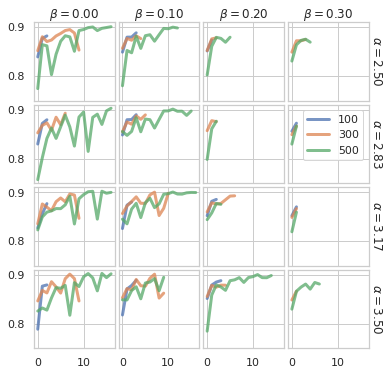

In [50]:
fig, axes = plt.subplots(m, n, figsize=(n*1.5, m*1.5), sharey=True, sharex=True)
for i, alpha in enumerate(step_alphas):
  for j, beta in enumerate(step_betas):
    for batch_size in batch_sizes:
      axes[i, j].plot(sgd_step_results[alpha][beta][batch_size]['accuracy'],
                      label=f'{batch_size:.0f}',
                      linewidth=3,
                      alpha=0.75)
      # axes[i, j].set_ylim([0.7, 0.87])
    # axes[i, j].set_xscale('symlog')

for i, alpha in enumerate(step_alphas):
  axes[i, -1].yaxis.set_label_position('right')
  axes[i, -1].set_ylabel(f'$\\alpha={alpha:.2f}$', rotation=-90)
  axes[i, -1].yaxis.set_label_coords(1.17, 0.5)

for j, beta in enumerate(step_betas):
  axes[0, j].xaxis.set_label_position('top')
  axes[0, j].set_xlabel(f'$\\beta={beta:.2f}$')
  
axes[1, -1].legend()

plt.subplots_adjust(wspace=0.05, hspace=0.05)
# plt.savefig('/content/drive/MyDrive/mmp_gd/accur_step_batch.pdf', bbox_inches='tight')
plt.show()

- При 100 метод просто застревает и быстро останавливается
- При 500 достигает большей точности, что логично, т.к. с увеличением `batch_size` SGD больше похож на GD.

## Шаг & `batch_size` vs loss

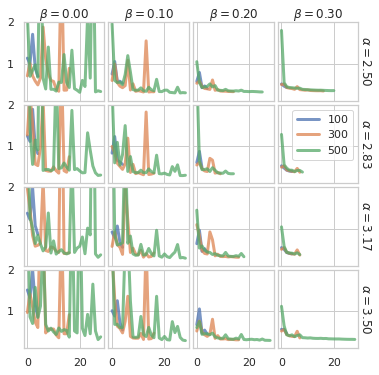

In [ ]:
fig, axes = plt.subplots(m, n, figsize=(n*1.5, m*1.5), sharey=True, sharex=True)
for i, alpha in enumerate(step_alphas):
  for j, beta in enumerate(step_betas):
    for batch_size in batch_sizes:
      axes[i, j].plot(sgd_step_results[alpha][beta][batch_size]['func'],
                      label=f'{batch_size:.0f}',
                      linewidth=3,
                      alpha=0.75)
      axes[i, j].set_ylim([0.1, 2])

for i, alpha in enumerate(step_alphas):
  axes[i, -1].yaxis.set_label_position('right')
  axes[i, -1].set_ylabel(f'$\\alpha=${alpha:.2f}', rotation=-90)
  axes[i, -1].yaxis.set_label_coords(1.17, 0.5)

for j, beta in enumerate(step_betas):
  axes[0, j].xaxis.set_label_position('top')
  axes[0, j].set_xlabel(f'$\\beta=${beta:.2f}')
  
axes[1, -1].legend()

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig('/content/drive/MyDrive/mmp_gd/loss_step_batch.pdf', bbox_inches='tight')
plt.show()

In [ ]:
dill.dump_session('/content/drive/MyDrive/mmp_gd/session.db')

## $w_0$ vs accuracy

In [ ]:
sgd_init_results = []
for init in tqdm(init_methods):
  w_0 = init(size=bow.shape[1])
  gd_model = SGDClassifier(batch_size=500, max_iter=1000, step_alpha=3.57, step_beta=0.086)
  history = gd_model.fit(bow, y_train, w_0=w_0, trace=True, log_freq=0.4)
  history['accuracy'] = calc_accuracy(history['weights'])
  history['score'] = calc_final_accuracy(history['weights'][-1])
  del history['weights']
  sgd_init_results.append(history)

  0%|          | 0/9 [00:00<?, ?it/s]

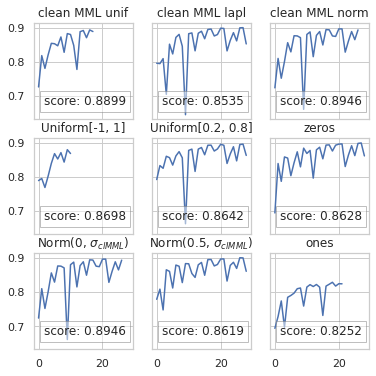

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(6,6), sharex=True, sharey=True)

init_scores = np.empty((3,3))
for k, name in enumerate(method_names):
  axes[k//3, k%3].plot(sgd_init_results[k]['accuracy'])
  axes[k//3, k%3].set_title(name)
  score = sgd_init_results[k]['score']
  init_scores[k//3, k%3] = score
  t = axes[k//3, k%3].text(0.1, 0.15,
                       f'score: {score:.4f}',
                       transform=axes[k//3, k%3].transAxes)
  t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='grey'))

plt.savefig('/content/drive/MyDrive/mmp_gd/sgd_init_weights.pdf', bbox_inches='tight')
plt.show()

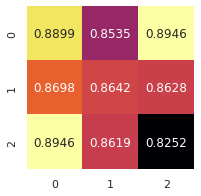

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(init_scores, annot=True, cbar=False, fmt='.4f', cmap='inferno', ax=ax)
plt.savefig('/content/drive/MyDrive/mmp_gd/sgd_accur_init_weights.pdf', bbox_inches='tight')
plt.show()

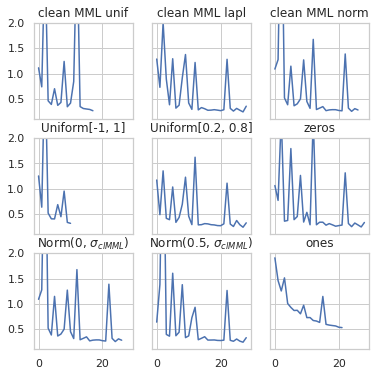

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(6,6), sharex=True, sharey=True)

init_scores = np.empty((3,3))
for k, name in enumerate(method_names):
  axes[k//3, k%3].plot(sgd_init_results[k]['func'])
  axes[k//3, k%3].set(title=name,
                      # xscale='log',
                      ylim=[0.1,2])

plt.savefig('/content/drive/MyDrive/mmp_gd/sgd_init_weights_loss.pdf', bbox_inches='tight')
plt.show()

# Эксперимент 6. Сравнение GD и SGD

здесь будет сравнение времени счета и итоговая точность в зависимости от цисла итераций.

In [27]:
gd_model = GDClassifier(max_iter=1000, step_alpha=2, step_beta=0.21)
gd_history = gd_model.fit(bow, y_train, trace=True)
gd_history['accuracy'] = calc_accuracy(gd_history['weights'])
del gd_history['weights']

In [94]:
sgd_model = SGDClassifier(batch_size=500, max_iter=1500, step_alpha=3.57, step_beta=0.086)
sgd_history = sgd_model.fit(bow, y_train, trace=True, log_freq=1)
sgd_history['accuracy'] = calc_accuracy(sgd_history['weights'])
del sgd_history['weights']

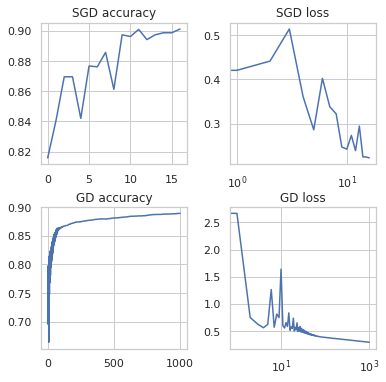

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(6,6))

axes[0,0].plot(sgd_history['accuracy'])
axes[0,1].plot(sgd_history['func'])

axes[1,0].plot(gd_history['accuracy'])
axes[1,1].plot(gd_history['func'])

axes[0,1].set_xscale('log')
axes[1,1].set_xscale('log')

axes[0,0].set_title('SGD accuracy')
axes[0,1].set_title('SGD loss')
axes[1,0].set_title('GD accuracy')
axes[1,1].set_title('GD loss')

axes[0,0].get_shared_y_axes().join(axes[1,0])
axes[0,1].get_shared_y_axes().join(axes[1,1])

plt.subplots_adjust(wspace=0.3, hspace=0.3)
# plt.savefig('/content/drive/MyDrive/mmp_gd/gd_sgd.pdf', bbox_inches='tight')
plt.show()

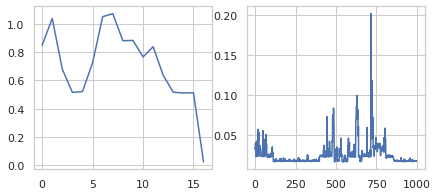

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Эксперимент 7. Лемматизация

Примените алгоритм лемматизации (например, `WordNetLemmatizer` из библотеки `nltk`) к коллекции. Удалите из текста стоп-слова (например, используя список стоп-слов из `nltk`). Исследуйте, как предобработка
корпуса повлияла на точность классификации, время работы алгоритма и размерность признакового пространства.

In [100]:
def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.ADJ, 'V': wordnet.VERB,
        'N': wordnet.NOUN, 'R': wordnet.ADV
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.NOUN

def simple_lemmatizer(sentence):
    lemmatizer = WordNetLemmatizer()
    tokenized_sent = sentence.split()
    pos_taged = [
        (word, get_wordnet_pos(tag))
        for word, tag in pos_tag(tokenized_sent)
    ]
    return " ".join([
        lemmatizer.lemmatize(word, tag)
        for word, tag in pos_taged
    ])

def lemmatize(column):
  return column.apply(simple_lemmatizer)

def remove_stopwords(column):
  global stopWords
  pat = r'\b(?:{})\b'.format('|'.join(stopWords))
  ans = column.str.replace(pat, '', regex=True)
  ans = ans.str.replace(r'\s+', ' ', regex=True)
  return ans

In [101]:
lemmatized = lemmatize(df.comment_text)
lemmatized_val = lemmatize(df_val.comment_text)
lemmatized_test = lemmatize(df_test.comment_text)

In [102]:
wo_stopwords = remove_stopwords(df.comment_text)
wo_stopwords_val = remove_stopwords(df_val.comment_text)
wo_stopwords_test = remove_stopwords(df_test.comment_text)

In [103]:
lem_wo_stop = remove_stopwords(lemmatized)
lem_wo_stop_val = remove_stopwords(lemmatized_val)
lem_wo_stop_test = remove_stopwords(lemmatized_test)

In [104]:
bow_vectorizer2 = CountVectorizer(min_df=0.0001)

bow_lem = bow_vectorizer2.fit_transform(lemmatized)
bow_lem_val = bow_vectorizer2.transform(lemmatized_val)
bow_lem_test = bow_vectorizer.transform(lemmatized_test)

bow_wo_stop = bow_vectorizer2.fit_transform(wo_stopwords)
bow_wo_stop_val = bow_vectorizer2.transform(wo_stopwords_val)
bow_wo_stop_test = bow_vectorizer2.transform(wo_stopwords_test)

bow_lem_wo_stop = bow_vectorizer2.fit_transform(lem_wo_stop)
bow_lem_wo_stop_val = bow_vectorizer2.transform(lem_wo_stop_val)
bow_lem_wo_stop_test = bow_vectorizer2.transform(lem_wo_stop_test)

In [136]:
bow.shape

(41649, 15948)

In [105]:
bow_lem.shape

(41649, 12992)

In [106]:
bow_wo_stop.shape

(41649, 15805)

In [107]:
bow_lem_wo_stop.shape

(41649, 12862)

In [153]:
new_gd_model = GDClassifier(max_iter=1000, step_alpha=2.21, step_beta=0.21)

history = new_gd_model.fit(bow, y_train, trace=True)
lem_history = new_gd_model.fit(bow_lem, y_train, trace=True)
wo_stop_history = new_gd_model.fit(bow_wo_stop, y_train, trace=True)
lem_wo_stop_history = new_gd_model.fit(bow_lem_wo_stop, y_train, trace=True)

In [154]:
def new_calc_accuracy(X, y, weights_history):
  accuracy = []
  for weights in weights_history:    
    y_pred = np.sign(X @ weights)
    score = (y_pred == y).mean()
    accuracy.append(score)
  return accuracy

In [155]:
history['accuracy'] = new_calc_accuracy(bow_val, y_val, history['weights'])
lem_history['accuracy'] = new_calc_accuracy(bow_lem_val, y_val, lem_history['weights'])
wo_stop_history['accuracy'] = new_calc_accuracy(bow_wo_stop_val, y_val, wo_stop_history['weights'])
lem_wo_stop_history['accuracy'] = new_calc_accuracy(bow_lem_wo_stop_val, y_val, lem_wo_stop_history['weights'])

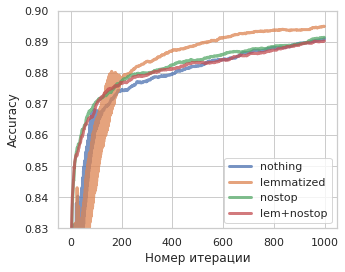

In [157]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(history['accuracy'], label='nothing', alpha=0.75, linewidth=3)
ax.plot(lem_history['accuracy'], label='lemmatized', alpha=0.75, linewidth=3)
ax.plot(wo_stop_history['accuracy'], label='nostop', alpha=0.75, linewidth=3)
ax.plot(lem_wo_stop_history['accuracy'], label='lem+nostop', alpha=0.75, linewidth=3)
ax.legend()
# ax.set_xscale('log')
ax.set_ylim([0.83,0.9])
ax.set(xlabel='Номер итерации', ylabel='Accuracy')
# plt.savefig('/content/drive/MyDrive/mmp_gd/nlp_stuff.pdf', bbox_inches='tight')
plt.show()

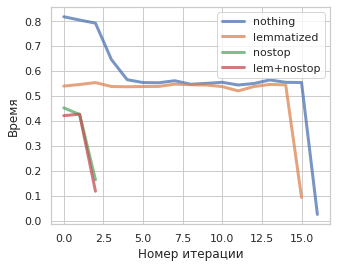

In [135]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(history['time'], label='nothing', alpha=0.75, linewidth=3)
ax.plot(lem_history['time'], label='lemmatized', alpha=0.75, linewidth=3)
ax.plot(wo_stop_history['time'], label='nostop', alpha=0.75, linewidth=3)
ax.plot(lem_wo_stop_history['time'], label='lem+nostop', alpha=0.75, linewidth=3)
ax.legend()
# ax.set_xscale('log')
# ax.set_ylim([0.83,0.9])
ax.set(xlabel='Номер итерации', ylabel='Время')
# plt.savefig('/content/drive/MyDrive/mmp_gd/nlp_stuff_time.pdf', bbox_inches='tight')
plt.show()

включает ли удаление стоп слов лематизацию?


# Эксперимент 8. BoW и TfIdf

In [247]:
def vectorize(min_df):
  t_vectorizer = TfidfVectorizer(min_df=min_df)
  b_vectorizer = CountVectorizer(min_df=min_df)
  
  t = t_vectorizer.fit_transform(lemmatized)
  t_val = t_vectorizer.transform(lemmatized_val)

  b = b_vectorizer.fit_transform(lemmatized)
  b_val = b_vectorizer.transform(lemmatized_val)

  model = GDClassifier(max_iter=1000, step_alpha=1.1, step_beta=0.15)
  t_history = model.fit(t, y_train, trace=True)

  model = GDClassifier(max_iter=1000, step_alpha=1.1, step_beta=0.15)
  b_history = model.fit(b, y_train, trace=True)

  t_history['accuracy'] = new_calc_accuracy(t_val, y_val, t_history['weights'])
  b_history['accuracy'] = new_calc_accuracy(b_val, y_val, b_history['weights'])
  del t_history['weights']
  del b_history['weights']
  
  t_history['feat_count'] = t.shape[1]
  b_history['feat_count'] = b.shape[1]

  return t_history, b_history

In [257]:
min_dfs = np.logspace(-4,-1, 4)
# min_dfs = [1e-4, 1e-3]
vect_results = defaultdict(dict)
for min_df in tqdm(min_dfs):
  t_history, b_history = vectorize(min_df)
  vect_results['bow'][min_df] = b_history
  vect_results['tfidf'][min_df] = t_history

  0%|          | 0/4 [00:00<?, ?it/s]

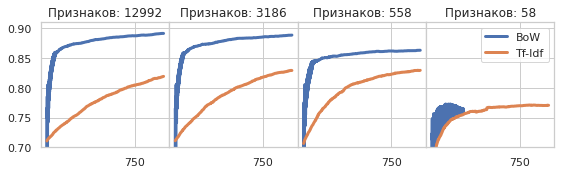

In [258]:
fig, axes = plt.subplots(1, len(min_dfs), figsize=(2.3 * len(min_dfs),2.3), sharex=True, sharey=True)

for i, min_df in enumerate(min_dfs):
  axes[i].plot(vect_results['bow'][min_df]['accuracy'], label='BoW', linewidth=3)
  axes[i].plot(vect_results['tfidf'][min_df]['accuracy'], label='Tf-Idf', linewidth=3)
  
  axes[i].set_ylim([0.7,0.91])
  axes[i].set_xticks([750])
  # axes[i].set(xlabel='Номер итерации', ylabel='Accuracy')

  size = vect_results['tfidf'][min_df]['feat_count']
  axes[i].set(title=f'Признаков: {size}')

axes[-1].legend()

plt.savefig('/content/drive/MyDrive/mmp_gd/tfidf_bow.pdf', bbox_inches='tight')
plt.subplots_adjust(wspace=0)
plt.show()

In [230]:
b_time = []
t_time = []
for min_df in min_dfs:
  time = np.sum(vect_results['bow'][min_df]['time'])
  b_time.append(time)
  time = np.sum(vect_results['tfidf'][min_df]['time'])
  t_time.append(time)

In [233]:
b_time

[20.595070123672485, 17.32121515274048, 14.094513893127441, 8.580769062042236]

In [234]:
t_time

[13.103339195251465, 12.167513132095337, 9.545028686523438, 3.9764325618743896]

# Эксперимент 9. Поиск лучше модели и анализ ошибок


In [267]:
b_vectorizer = CountVectorizer(min_df=1e-4)

b = b_vectorizer.fit_transform(lemmatized)
b_val = b_vectorizer.transform(lemmatized_val)

## Оптимальный шаг GD

In [275]:
def calc_final_accuracy(weights):
  global b_val, y_val
  y_pred = np.sign(b_val @ weights)
  return (y_pred == y_val).mean()

def calc_accuracy(weights_history):
  global b_val, y_val
  accuracy = []
  for weights in weights_history:    
    y_pred = np.sign(b_val @ weights)
    score = (y_pred == y_val).mean()
    accuracy.append(score)
  return accuracy

In [277]:
m = 8
n = 8
step_alphas = np.linspace(1.5, 2.5, m)
step_betas = np.linspace(0.1, 0.3, n)
cv_results = {'score': np.empty((m, n))}
for i, alpha in tqdm(enumerate(step_alphas), desc='loop alpha'):
  cv_results[alpha] = {}
  for j, beta in tqdm(enumerate(step_betas), desc='loop beta'):
    gd_model = GDClassifier(max_iter=1000, step_alpha=alpha, step_beta=beta)
    history = gd_model.fit(b, y_train, trace=True)
    del history['time']
    cv_results['score'][i, j] = calc_final_accuracy(gd_model.coefs)
    history['accuracy'] = calc_accuracy(history['weights'])
    del history['weights']
    cv_results[alpha][beta] = history

loop alpha: 0it [00:00, ?it/s]

loop beta: 0it [00:00, ?it/s]

loop beta: 0it [00:00, ?it/s]

loop beta: 0it [00:00, ?it/s]

loop beta: 0it [00:00, ?it/s]

loop beta: 0it [00:00, ?it/s]

loop beta: 0it [00:00, ?it/s]

loop beta: 0it [00:00, ?it/s]

loop beta: 0it [00:00, ?it/s]

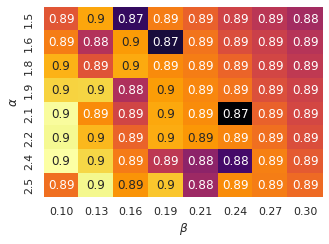

In [281]:
fig, ax = plt.subplots(figsize=(5,3.5))
sns.heatmap(cv_results['score'], annot=True, cbar=False, cmap='inferno', ax=ax)
ax.set(ylabel=r'$\alpha$', xlabel=r'$\beta$')
ax.set(yticklabels=[f'{a:.1f}' for a in step_alphas],
       xticklabels=[f'{b:.2f}' for b in step_betas],)
plt.savefig('/content/drive/MyDrive/mmp_gd/accur_step.pdf', bbox_inches='tight')
plt.show()

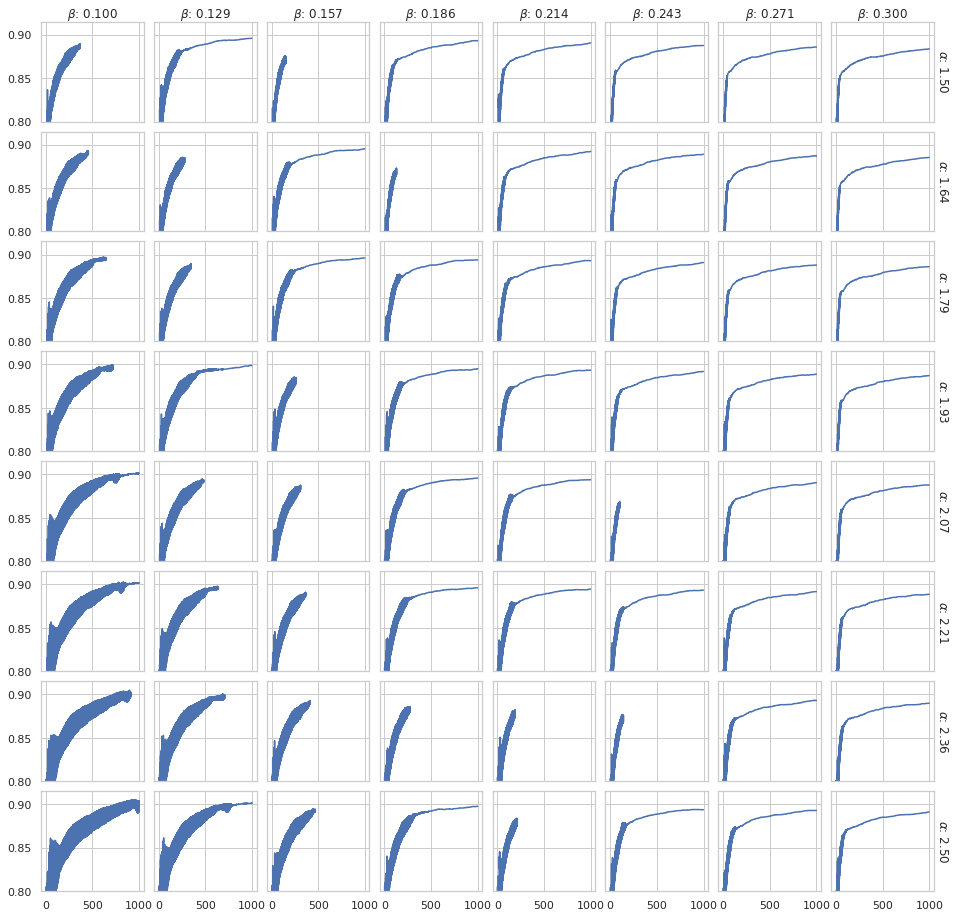

In [282]:
fig, axes = plt.subplots(m, n, figsize=(n*2, m*2), sharey=True, sharex=True)
for i, alpha in enumerate(step_alphas):
  for j, beta in enumerate(step_betas):
    axes[i, j].plot(cv_results[alpha][beta]['accuracy'])    
    axes[i, j].set_ylim([0.8, 0.915])
    # axes[i, j].set_xscale('symlog')

for i, alpha in enumerate(step_alphas):
  axes[i, -1].yaxis.set_label_position('right')
  axes[i, -1].set_ylabel(f'$\\alpha$: {alpha:.2f}', rotation=-90)
  axes[i, -1].yaxis.set_label_coords(1.15, 0.5)

for j, beta in enumerate(step_betas):
  axes[0, j].xaxis.set_label_position('top')
  axes[0, j].set_xlabel(f'$\\beta$: {beta:.3f}')
  
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

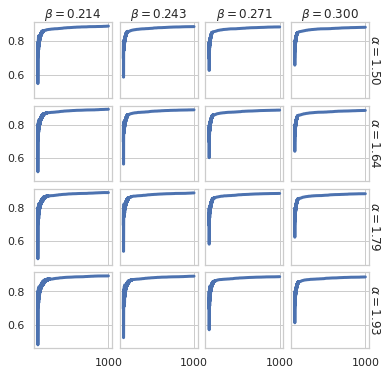

In [283]:
fig, axes = plt.subplots(4, 4, figsize=(6, 6), sharey=True, sharex=True)
for i, alpha in enumerate(step_alphas[:4]):
  for j, beta in enumerate(step_betas[4:]):
    axes[i, j].plot(cv_results[alpha][beta]['accuracy'], linewidth=3)
                    # label=f'$\\alpha=${alpha:.2f}\n$\\beta=${beta:.2f}')
    # axes[i, j].set_ylim([0.8, 0.9])
    axes[i, j].set(xticks=[1000])

for i, alpha in enumerate(step_alphas[:4]):
  axes[i, -1].yaxis.set_label_position('right')
  axes[i, -1].set_ylabel(f'$\\alpha=${alpha:.2f}', rotation=-90)
  axes[i, -1].yaxis.set_label_coords(1.15, 0.5)

for j, beta in enumerate(step_betas[4:]):
  axes[0, j].xaxis.set_label_position('top')
  axes[0, j].set_xlabel(f'$\\beta=${beta:.3f}')
  
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('/content/drive/MyDrive/mmp_gd/accur_step_best.pdf', bbox_inches='tight')
plt.show()

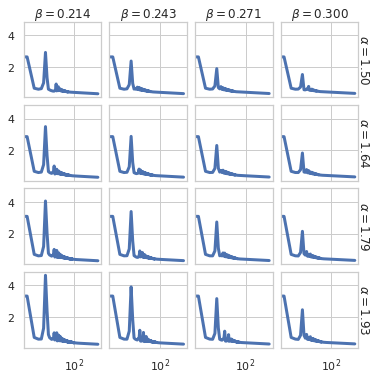

In [284]:
fig, axes = plt.subplots(4, 4, figsize=(6, 6), sharey=True, sharex=True)
for i, alpha in enumerate(step_alphas[:4]):
  for j, beta in enumerate(step_betas[4:]):
    axes[i, j].plot(cv_results[alpha][beta]['func'], linewidth=3)
                    # label=f'$\\alpha=${alpha:.2f}\n$\\beta=${beta:.2f}')
    # axes[i, j].set_ylim([0.8, 0.9])
    axes[i, j].set(xticks=[1000])
    axes[i, j].set(xscale='log')

for i, alpha in enumerate(step_alphas[:4]):
  axes[i, -1].yaxis.set_label_position('right')
  axes[i, -1].set_ylabel(f'$\\alpha=${alpha:.2f}', rotation=-90)
  axes[i, -1].yaxis.set_label_coords(1.15, 0.5)

for j, beta in enumerate(step_betas[4:]):
  axes[0, j].xaxis.set_label_position('top')
  axes[0, j].set_xlabel(f'$\\beta=${beta:.3f}')
  
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('/content/drive/MyDrive/mmp_gd/loss_step_best.pdf', bbox_inches='tight')
plt.show()

## Оптимальный шаг SGD

In [285]:
m = 8
n = 8
step_alphas = np.linspace(2.5, 4, m)
step_betas = np.linspace(0, 0.3, n)
sgd_cv_results = {'score': np.empty((m, n))}
for i, alpha in tqdm(enumerate(step_alphas), desc='alpha'):
  sgd_cv_results[alpha] = {}
  for j, beta in tqdm(enumerate(step_betas), desc='beta'):
    sgd_model = SGDClassifier(batch_size=500, max_iter=1000, step_alpha=alpha, step_beta=beta)
    history = sgd_model.fit(b, y_train, trace=True, log_freq=0.5)
    del history['time']
    sgd_cv_results['score'][i, j] = calc_final_accuracy(sgd_model.coefs)
    history['accuracy'] = calc_accuracy(history['weights'])
    del history['weights']
    sgd_cv_results[alpha][beta] = history

alpha: 0it [00:00, ?it/s]

beta: 0it [00:00, ?it/s]

beta: 0it [00:00, ?it/s]

beta: 0it [00:00, ?it/s]

beta: 0it [00:00, ?it/s]

beta: 0it [00:00, ?it/s]

beta: 0it [00:00, ?it/s]

beta: 0it [00:00, ?it/s]

beta: 0it [00:00, ?it/s]

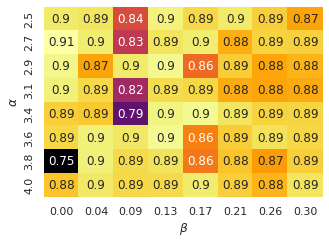

In [288]:
fig, ax = plt.subplots(figsize=(5,3.5))
sns.heatmap(sgd_cv_results['score'], annot=True, cbar=False, cmap='inferno', ax=ax)
ax.set(ylabel=r'$\alpha$', xlabel=r'$\beta$')
ax.set(yticklabels=[f'{a:.1f}' for a in step_alphas],
       xticklabels=[f'{b:.2f}' for b in step_betas],)
plt.savefig('/content/drive/MyDrive/mmp_gd/accur_step_stoch.pdf', bbox_inches='tight')
plt.show()

In [287]:
step_alphas

array([2.5       , 2.71428571, 2.92857143, 3.14285714, 3.35714286,
       3.57142857, 3.78571429, 4.        ])

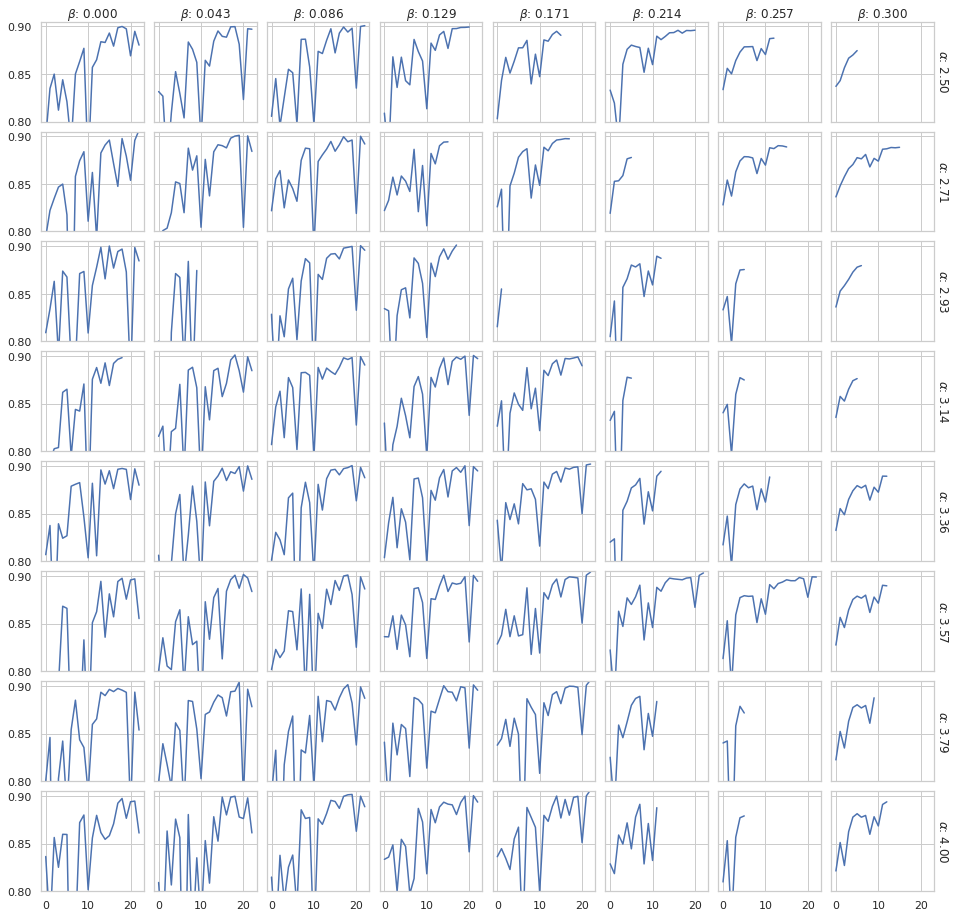

In [289]:
fig, axes = plt.subplots(m, n, figsize=(n*2, m*2), sharey=True, sharex=True)
for i, alpha in enumerate(step_alphas):
  for j, beta in enumerate(step_betas):
    axes[i, j].plot(sgd_cv_results[alpha][beta]['accuracy'])    
    axes[i, j].set_ylim([0.8, 0.905])
    # axes[i, j].set_xscale('symlog')

for i, alpha in enumerate(step_alphas):
  axes[i, -1].yaxis.set_label_position('right')
  axes[i, -1].set_ylabel(f'$\\alpha$: {alpha:.2f}', rotation=-90)
  axes[i, -1].yaxis.set_label_coords(1.15, 0.5)

for j, beta in enumerate(step_betas):
  axes[0, j].xaxis.set_label_position('top')
  axes[0, j].set_xlabel(f'$\\beta$: {beta:.3f}')
  
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

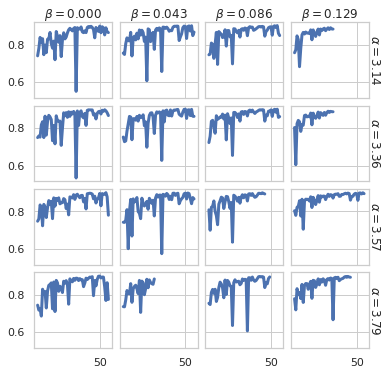

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(6, 6), sharey=True, sharex=True)
for i, alpha in enumerate(step_alphas[3:-1]):
  for j, beta in enumerate(step_betas[:4]):
    axes[i, j].plot(sgd_cv_results[alpha][beta]['accuracy'], linewidth=3)
                    # label=f'$\\alpha=${alpha:.2f}\n$\\beta=${beta:.2f}')
    # axes[i, j].set_ylim([0.8, 0.9])
    axes[i, j].set(xticks=[50])

for i, alpha in enumerate(step_alphas[3:-1]):
  axes[i, -1].yaxis.set_label_position('right')
  axes[i, -1].set_ylabel(f'$\\alpha=${alpha:.2f}', rotation=-90)
  axes[i, -1].yaxis.set_label_coords(1.15, 0.5)

for j, beta in enumerate(step_betas[:4]):
  axes[0, j].xaxis.set_label_position('top')
  axes[0, j].set_xlabel(f'$\\beta=${beta:.3f}')
  
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('/content/drive/MyDrive/mmp_gd/accur_step_best_stoch.pdf', bbox_inches='tight')
plt.show()

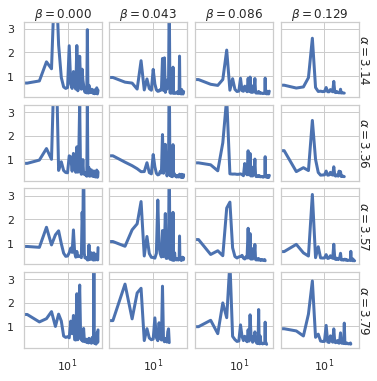

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(6, 6), sharey=True, sharex=True)
for i, alpha in enumerate(step_alphas[3:-1]):
  for j, beta in enumerate(step_betas[:4]):
    axes[i, j].plot(sgd_cv_results[alpha][beta]['func'], linewidth=3)
                    # label=f'$\\alpha=${alpha:.2f}\n$\\beta=${beta:.2f}')
    axes[i, j].set_ylim([0.1, 3.3])
    axes[i, j].set(xscale='log')

for i, alpha in enumerate(step_alphas[3:-1]):
  axes[i, -1].yaxis.set_label_position('right')
  axes[i, -1].set_ylabel(f'$\\alpha=${alpha:.2f}', rotation=-90)
  axes[i, -1].yaxis.set_label_coords(1.15, 0.5)

for j, beta in enumerate(step_betas[:4]):
  axes[0, j].xaxis.set_label_position('top')
  axes[0, j].set_xlabel(f'$\\beta=${beta:.3f}')
  
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('/content/drive/MyDrive/mmp_gd/loss_step_best_stoch.pdf', bbox_inches='tight')
plt.show()

## Контроль качества

In [290]:
b_vectorizer = CountVectorizer(min_df=1e-4)

b = b_vectorizer.fit_transform(lemmatized)
b_test = b_vectorizer.transform(lemmatized_test)

In [295]:
best_model = GDClassifier(max_iter=1500, step_alpha=1.93, step_beta=0.21)
history = best_model.fit(b, y_train, trace=True)
y_pred = best_model.predict(b_test)

0.8549042367962856


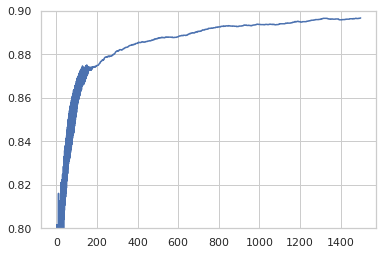

In [303]:
print((y_pred == y_test).mean())
accuracy = calc_accuracy(history['weights'])
plt.plot(accuracy)
plt.ylim([0.8,0.9])
plt.show()

In [308]:
fp_mask = (y_pred == 1) & (y_test == -1)
fp = df_test[fp_mask]
fp.shape

(2141, 2)

In [309]:
fn_mask = (y_pred == -1) & (y_test == 1)
fn = df_test[fn_mask]
fn.shape

(671, 2)

In [326]:
fp.to_csv('fp.csv')
fn.to_csv('fn.csv')

In [324]:
inds = np.argpartition(np.sign(b_test @ best_model.coefs * y_test), -10)[-10:]
df_test.loc[inds]

,comment_text,is_toxic
7433,signed thanks for the invite,False
7439,you currently appear to be engaged in an edit ...,False
7423,thanks salvio that could come in handy i ll en...,False
7430,f uck you you are an ass hole and a bi tch wh ore,True
7429,you idiot i m only kidding,True
7428,chinese term are according to this article the...,False
7427,the issue about einstein,False
7426,i think i understand your points but i don t t...,False
7424,redirect talk marie of swabia,False
20675,mel gibson is a nazi bitch who makes shitty mo...,True
